# HAT-P-23b Transit Data Reduction and Analysis

Brianna Isola

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import stats
from scipy.stats import norm
from datetime import datetime, timedelta

%matplotlib inline

#### Generating a Master Dark

Creating master dark with 1-minute exposure time to match our data exposure time.

In [2]:
# generating master dark image

dark_num  = [1,2,3,4,5,6,7,8,9,10]
dark_list = []

for n in dark_num:
    
    if n < 10:
        file_name = 'btm_hat_p23_b_DARK.0000000'+str(n)+'.DARK.FIT'
    else:
        file_name = 'btm_hat_p23_b_DARK.000000'+str(n)+'.DARK.FIT'

    file_open = fits.open(file_name)      # open file
    file_list = file_open[0].data         # pull selected data (counts)
    
    dark_list.append(file_list)    

dark_arr    = np.array(dark_list)
dark_avrg   = np.median(dark_arr, axis=0)  # calaculate mean of all images
master_dark = dark_avrg.flatten()          # create master image

# saving file to system 
#mdrk = fits.PrimaryHDU(dark_avrg)
#mdrk.writeto('master_dark_lab1.FIT')

A median combine is better for creating the master dark as the median value will be less affected by hot pixels than the mean.

#### Generating a Master Flat Field

We now create a master flat field image from 2-second exposure dome flats.

In [3]:
# 'btm_hat_p23_b_FLAT.00000228.FLAT'

flat_num  = np.linspace(228,236,9)
flat_list = []

for n in flat_num:
    
    n = int(n)
    file_name = 'btm_hat_p23_b_FLAT.00000'+str(n)+'.FLAT.FIT'

    file_open = fits.open(file_name)      # open file
    file_list = file_open[0].data         # pull selected data (counts)
    
    flat_list.append(file_list)    

flat_arr    = np.array(flat_list)
flat_avrg   = np.median(flat_arr, axis=0) # calaculate mean of all images
unnorm_flat = flat_avrg.flatten()         # create master image, unnormalized

flat_mode     = stats.mode(unnorm_flat)[0][0]
master_flat_u = flat_avrg/flat_mode
master_flat   = master_flat_u.flatten()   

# saving file to system 
#mflt = fits.PrimaryHDU(master_flat_u)
# mflt.writeto('master_flat_lab1.FIT')

#### Processing the Science images

We then apply the master dark and master flat to our science images. This can also be done in pyraf.

In [4]:
img_num  = np.linspace(1,226,226)
img_list = []

for n in img_num:
    
    n = int(n)

    if n < 10:
        file_name = 'btm_hat_p23_b_exo.0000000'+str(n)+'.FIT'
    elif n >= 10 and n < 100:
        file_name = 'btm_hat_p23_b_exo.000000'+str(n)+'.FIT'
    elif n >= 100:
        if n == 104:
            n = n+1
        file_name = 'btm_hat_p23_b_exo.00000'+str(n)+'.FIT'

    file_open = fits.open(file_name)      # open file
    file_list = file_open[0].data         # pull selected data (counts)
    file_img  = file_list.flatten()       # create master image
    
    # appling master dark and flat
    #new_img = (file_img-master_dark)/master_flat
    new_img   = (file_list-dark_avrg)/master_flat_u
    
    # saving all images to a list
    img_list.append(new_img)    

sci_img = np.array(img_list)           # array of all science images corrected with master dark and flat


In [5]:
# check
file_name = 'btm_hat_p23_b_FLAT.00000237.FLAT.FIT'
file_open = fits.open(file_name)      # open file
file_list = file_open[0].data         # pull selected data (counts)
file_img  = file_list.flatten()       # create master image
file_open.info()
file_open[0].header['DATE-OBS']
#print(t_UTC[100],t_UTC[101],t_UTC[102],t_UTC[103])

Filename: btm_hat_p23_b_FLAT.00000237.FLAT.FIT
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      45   (1024, 1024)   uint16   


'2019-09-19T05:09:31.202'

#### Generating a Bad Pixel Mask

We generate a bad pixel map that identifies the hot and dead pixels in our images. The bad pixels are found to be the outliers in the count distribution of our two master frames. We define our outlying values to be $\pm4\sigma$ (satndard deviations) from the mean:

In [6]:
# defining 4-sigma  clipping for outlying pixels

def cutoff_mx(x):
    sig4 = np.std(x)*4
    ans  = round(np.mean(x)+sig4,2)
    return ans

def cutoff_mn(x):
    sig4 = np.std(x)*4
    ans  = round(np.mean(x)-sig4,2)
    return ans

We apply the 4-sigma clip to our master dark frame to identify hot pixels:

percent rejected = 0.0841 %


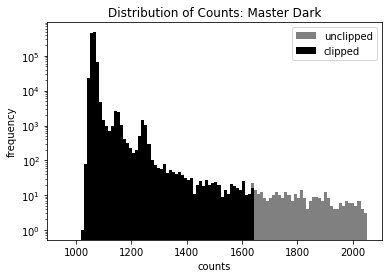

In [7]:
# plotting master dark on histogram

nbins = 100  # number of bins
pmax  = 2050 # max scale of historgram
pmin  = 950  # min scale '  '

# defining clipped values
drk_cmax = cutoff_mx(master_dark)
drk_cmin = cutoff_mn(master_dark)

# calculating cutoff of 3std from mean
drk_clip = master_dark[(master_dark<=drk_cmax)&(master_dark>=drk_cmin)]

plt.hist(master_dark,range=[pmin,pmax],bins=nbins,color='gray',label='unclipped')
plt.hist(drk_clip,range=[pmin,pmax],bins=nbins,color='k',label='clipped')

plt.title('Distribution of Counts: Master Dark')
plt.xlabel('counts')
plt.ylabel('frequency')
plt.yscale('log', nonposy='clip')
plt.legend()

# check
#print('std (unclipped)  =',round(np.std(master_dark),2))
#print('std (clipped)    =',round(np.std(drk_clip),2))

pix_rejected = round(1-len(drk_clip)/len(master_dark),6)
print('percent rejected =',100*pix_rejected,'%')

plt.savefig('L101.png')


We can see the 4-sigma clip is valid for removing the outliers from our master dark and 0.0841% of the total pixels were clipped. We now apply the same clipping to our master flat to idenitfy dead pixels:

percent rejected = 0.10039999999999999 %


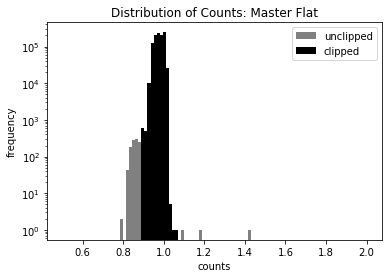

In [8]:
# calculating cutoff of 4std from mean

nbins = 100
pmax  = 2.0
pmin  = 0.5

flt_cmax = cutoff_mx(master_flat)
flt_cmin = cutoff_mn(master_flat)

# calculating cutoff of 3std from mean
flt_clip = master_flat[(master_flat<=flt_cmax)&(master_flat>=flt_cmin)]

plt.hist(master_flat,range=[0.5,2.0],bins=100,color='gray',label='unclipped')
plt.hist(flt_clip,range=[0.5,2.0],bins=100,color='k',label='clipped')
plt.title('Distribution of Counts: Master Flat')
plt.xlabel('counts')
plt.ylabel('frequency')
plt.yscale('log', nonposy='clip')
plt.legend()

plt.savefig('L102.png')


pix_rejected = round(1-len(flt_clip)/len(master_flat),6)
print('percent rejected =',100*pix_rejected,'%')

For our 4-sigma clip of our master flat, about 0.1% of all pixels were rejectecd. We now the take rejected pixels from both master frames and create our bad pixel map:

In [9]:
# creating bad pixel map

# defining cutoffs for master dark and master flat

drk_cmax = cutoff_mx(master_dark)
drk_cmin = cutoff_mn(master_dark)

flt_cmax = cutoff_mx(master_flat)
flt_cmin = cutoff_mn(master_flat)

# creating blank map with correct array dimensions

pixmap = dark_avrg*0

# finding dark pix

for i in range(len(pixmap)):
    for j in range(len(pixmap[i])):
        val = dark_avrg[i][j]
        #print(val)
        if val>drk_cmax or val<drk_cmin:
            pixmap[i][j] = 0
        else:
            pixmap[i][j] = 1
            
# finding hot pix      

for i in range(len(pixmap)):
    for j in range(len(pixmap[i])):
        val = master_flat_u[i][j]
        #print(val)
        if val>flt_cmax or val<flt_cmin:
            pixmap[i][j] = 0 
            
            #  since we already set all good pix to 1 in the first loop,
            #   > we do not need to do it here, or it will overwrite all
            #   > the found dark pixels
            
            # (could also probably combine these loops, but this seemed fine)


We set good pixels equal to 1, and bad pixels equal to 0. We can also view the bad pixel map without Ds9 below:

Text(0,0.5,'pix')

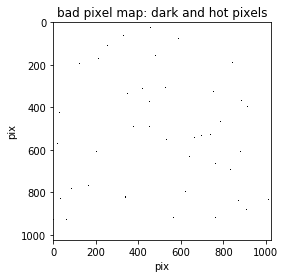

In [10]:
fltimg = fits.open('pixelmap01.FIT') 
plt.imshow(fltimg[0].data, cmap='gray')
plt.title('bad pixel map: dark and hot pixels')
# plt.colorbar()  # shows colorbar, optional
plt.xlabel('pix')
plt.ylabel('pix')


#### Aligning the images

The newly calibrated images were solved for their WCS using Astrometry.net and the Stony Brook Astrolab computers.


#### Aperture Photometry on Target and Calibration Stars

Images processed through the Source Extrator on the Stony Brook Astrolab machines with an aperture of 8.137 pixels. For our images, 10 refrence stars were chosen. For each star in each image, the time of observation, flux, and flux error was extracted. This was aslo done for the target planet-host system. The extracted data is saved in .dat files, and each refrence stars right ascension and declination values are listed within the report.




#### Lightcurves of reference stars

For each refrence star $j$, we rescaled both the flux and error on the flux for each image,

$f_{j}(t) \rightarrow \frac{f_{j}(t)}{\left\langle f_{j}\right\rangle}$

$\sigma_{f_{j}(t)} \rightarrow \frac{\sigma_{f_{j}(t)}}{\left\langle f_{j}\right\rangle}$

This will help us to visualize the relative variations due to changes in airmass, the atmosphere, and intrinsic variations of stellar brightness.

In [11]:
# opening host star data
host_dat = open('host_data.dat')    

list = []
for line in host_dat:
    list += [line.split()]
RA       = [float(x[0]) for x in list] # RA  ; right ascension (deg.)
DEC      = [float(x[1]) for x in list] # DEC ; declination (dec.)
str_flux = [float(x[2]) for x in list] # f   ; flux of host star
str_ferr = [float(x[3]) for x in list] # error of flux of host star
t_UTC    = [x[5] for x in list]        # time images were taken (UT)
str_mn   = np.mean(str_flux)           # mean flux

host_dat.close()



# master lists to hold data for all ref. stars
flux_lst     = [] # flux
ferr_lst     = [] # error of flux
fmean_lst    = [] # mean flux
flux_adj_lst = [] # flux adjusted (flux/mean)
ferr_adj_lst = [] # err. of flux adjusted (ferr/mean)

# open data 
r0_dat = open('refstar1_data.dat') # due to python indexing, changed 1->0
r1_dat = open('refstar2_data.dat')
r2_dat = open('refstar3_data.dat')
r3_dat = open('refstar4_data.dat')
r4_dat = open('refstar5_data.dat')
r5_dat = open('refstar6_data.dat')
r6_dat = open('refstar7_data.dat')
r7_dat = open('refstar8_data.dat')
r8_dat = open('refstar9_data.dat')
r9_dat = open('refstar10_data.dat')

ref_lst = [r0_dat,r1_dat,r2_dat,r3_dat,r4_dat,r5_dat,r6_dat,r7_dat,r8_dat,r9_dat]

for ref in ref_lst:
    
    list = []
    for col in ref:
        list += [col.split()]          # split dat file into readable columns
        
    flux = [float(c[2]) for c in list] # flux of star
    ferr = [float(c[3]) for c in list] # error of flux of star
    mean = np.mean(flux)               # mean flux
    
    # dividing flux and error by mean to rescale values
    
    flx_adj = (flux/mean)              # adjusted flux by mean
    err_adj = (ferr/mean)              # adjusted flux.err by mean
    
    # add values to master lists
    
    flux_lst.append(flux)
    ferr_lst.append(ferr)
    fmean_lst.append(mean)
    flux_adj_lst.append(flx_adj)
    ferr_adj_lst.append(err_adj)
    
    # converting lists to arrays
    
    flux_adj = np.array(flux_adj_lst)
    ferr_adj = np.array(ferr_adj_lst)
    
    ref.close()


Here we convert our observation times to seconds passed since observation start. This will be the x-axis values used to plot of transit light curves:

In [12]:
# converting image time to seconds passed from observation start

t_adj_lst = []                                          # list to hold new time values
start_t = datetime.strptime(t_UTC[0],'%H:%M:%S.%f')     # observation start time

for i in range(0,225):
    
    curr_t  = datetime.strptime(t_UTC[i],'%H:%M:%S.%f') # current time of image at i
    new_t   = (curr_t-start_t).total_seconds()          # convert difference of time to seconds passed
    
    t_adj_lst.append(new_t)
    
t_x0 = np.array(t_adj_lst)

To continue to help us visualize the relative variations in our image, we plot the light curve of our host star below:

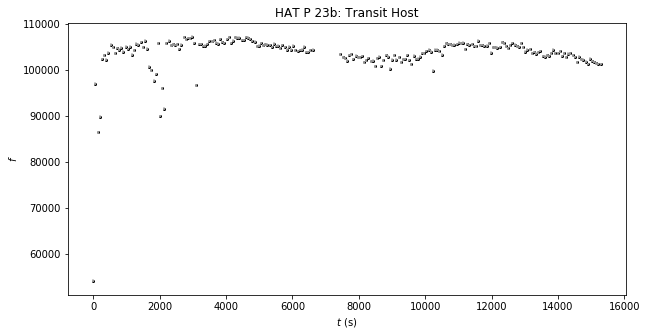

In [28]:
# HAT p 23b Transit lightcurve 

plt.figure(figsize=(10,5))
plt.scatter(t_x0,str_flux,color="black",s=4)
plt.errorbar(t_x0,str_flux,yerr = str_ferr, xerr = None, ecolor='silver',ls='none')
plt.title('HAT P 23b: Transit Host')
plt.xlabel('$t$ (s)')
plt.ylabel('$f$')
plt.show()

plt.savefig('L103b.png')


Here $f$ is the raw flux from our data and $t$ is the time passed since the start of observation. We now also plot the lightcurves of each of our scaled refrence stars:

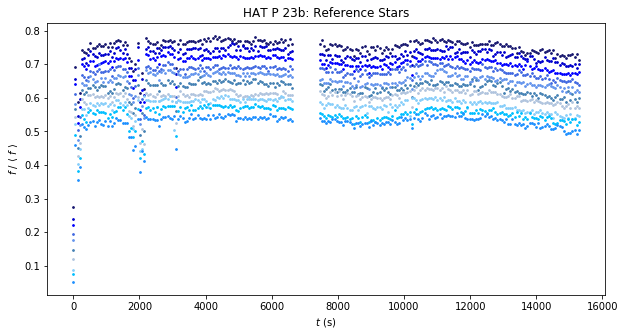

In [29]:
# HAT p 23b refrence star lightcurves

# color order for pretty plots
color = ['midnightblue','mediumblue','blue','royalblue','cornflowerblue','steelblue','lightsteelblue','lightskyblue','deepskyblue','dodgerblue']

# function to display all lightcurves on the same plot at an offset from each other
def plotmany(xdat,ydat):
    
    os_flux_lst = [] # list to hold offset flux values for multi-sta plot
    os_ferr_lst = [] # list to hold offset flux error values
    i       = 0
    offset  = 0.25   # initial offset
    inc     = 0.025  # increment value

    for ref in ydat:
        new_flux = [(x-offset) for x in ref]
        os_flux_lst.append(new_flux)
        offset = offset + inc

    os_flux = np.array(os_flux_lst)
    for ref in os_flux:
        plt.scatter(xdat,ref,s=3,c=color[i])
        i = i+1      

# plotting lightcurves
plt.figure(figsize=(10,5))
plotmany(t_x0,flux_adj)
plt.title('HAT P 23b: Reference Stars')
plt.xlabel('$t$ (s)')
plt.ylabel('$f \ / \ \\left \\langle \ f \ \\right \\rangle $')
plt.legend()
plt.savefig('L104.png')


We plotted all refrence lightcurves on the same grapth, such that each refrence star was offset by a small value. Across all lightcurves there is a drop in flux toward the middle and a few individual exposures whose fluxes are significantly lower than the others. We can remove these outlying exposures from our image by defining an exposure cutoff of any scaled flux < 0.98. 

Applying this cutoff to one reference star will indicate which exposures have this variation. Since the variations are consistent across all stars, we know those exposures had the same affect on all stars. Therefore, once we locate the outlying exposures, we can remove them from all our stars.

exposures removed =  25


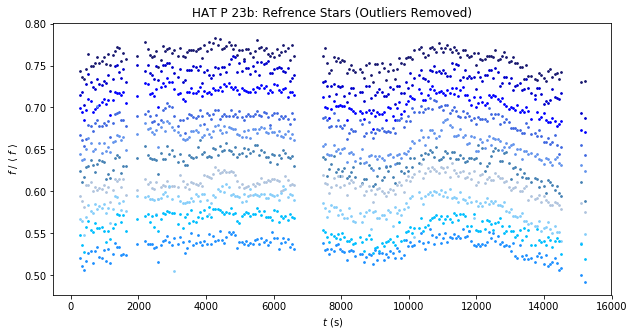

In [35]:
# correcting data by rejecting the first exposure + outliers

# findning and clipping outliers

def find_outliers(data,cutoff):
    ans = np.where(data<cutoff)
    return ans

# indices to remove at scaled flux cutoff of 0.98
indx  = find_outliers(np.array(flux_adj[0]),0.98) 

# deleting bad exposures from data
str_flux_c = np.delete(str_flux,indx)
str_ferr_c = np.delete(str_ferr,indx)
flux_adj_c = [np.delete(ref,indx) for ref in flux_adj]
ferr_adj_c = [np.delete(ref,indx) for ref in ferr_adj]
time_c     = np.delete(t_x0,indx)

# plot corrected refrence star lightcurves
plt.figure(figsize=(10,5))
plotmany(time_c,flux_adj_c)
plt.title('HAT P 23b: Refrence Stars (Outliers Removed)')
plt.xlabel('$t$ (s)')
plt.ylabel('$f \ / \ \\left \\langle \ f \ \\right \\rangle $')
plt.legend()

plt.savefig('L105.png')


# number of exposures removed
exp_rm = len(str_flux)-len(str_flux_c)
print('exposures removed = ',exp_rm)

For our host and refrence stars, 25 exposures were removed. We are able to get a better idea about the shape of our stellar lightcurves.


#### Calibration of the Science Target Photometry

While the outlying exposure frames were removed, changes in atmospheric conditions caused flux changes that were larger than the signal we are trying to detect. We see this as the dip in our flux values towards the middle of every light curve. As with our outlying exposures, we must correct for this to acuratley see the host star transit.

We now calculate flux of the target stars relative to the reference stars to account for these atmospheric changes. By averaging over several reference stars, we can reduce the statistical noise as well as systematic uncertainty from undetected variability in the reference stars. 

When computing the average flux of several stars, we compute the weighted mean:

$\mu_{i}^{\mathrm{ref}}=\frac{\Sigma_{j} f_{j}^{\mathrm{ref}} /\left(\sigma_{j}^{\mathrm{ref}}\right)^{2}}{\Sigma_{j} 1 /\left(\sigma_{j}^{\mathrm{ref}}\right)^{2}}$

as well as its error:

$\sigma_{i}^{\mathrm{ref}}=\sqrt{\frac{1}{\Sigma_{j} 1 /\left(\sigma_{j}^{\mathrm{ref}}\right)^{2}}}$

In [36]:
str_flux_c = np.delete(str_flux,indx)
flux_adj_c = np.array(flux_adj_c)
ferr_adj_c = np.array(ferr_adj_c)
t_UTC_c   = np.delete(t_UTC,indx)

mu_ref_lst  = []             # list to hold weighted mean values (mu)
sig_ref_lst = []             # list to hold error of weighted mean values (sig)
ratio_lst   = []             # list to hold ratio values
rerr_lst    = []             # list to hold ratio error values


for i in range(0,200):
    
    # calculating weighted mean (numerator)
    a0 = flux_adj_c[0][i]/(ferr_adj_c[0][i]**2)
    a1 = flux_adj_c[1][i]/(ferr_adj_c[1][i]**2)
    a2 = flux_adj_c[2][i]/(ferr_adj_c[2][i]**2)
    a3 = flux_adj_c[3][i]/(ferr_adj_c[3][i]**2)
    a4 = flux_adj_c[4][i]/(ferr_adj_c[4][i]**2)
    a5 = flux_adj_c[5][i]/(ferr_adj_c[5][i]**2)
    a6 = flux_adj_c[6][i]/(ferr_adj_c[6][i]**2)
    a7 = flux_adj_c[7][i]/(ferr_adj_c[7][i]**2)
    a8 = flux_adj_c[8][i]/(ferr_adj_c[8][i]**2)
    a9 = flux_adj_c[9][i]/(ferr_adj_c[9][i]**2)
    sum_a = (a0+a1+a2+a3+a4+a5+a6+a7+a8+a9)
    
    # calculating weighted mean (denominator)
    b0 = 1/(ferr_adj_c[0][i])**2
    b1 = 1/(ferr_adj_c[1][i])**2
    b2 = 1/(ferr_adj_c[2][i])**2
    b3 = 1/(ferr_adj_c[3][i])**2
    b4 = 1/(ferr_adj_c[4][i])**2
    b5 = 1/(ferr_adj_c[5][i])**2
    b6 = 1/(ferr_adj_c[6][i])**2
    b7 = 1/(ferr_adj_c[7][i])**2
    b8 = 1/(ferr_adj_c[8][i])**2
    b9 = 1/(ferr_adj_c[9][i])**2
    sum_b = (b0+b1+b2+b3+b4+b5+b6+b7+b8+b9)
    
    c  = sum_a/sum_b                # calculating weighted mean (mu)
        
    d  = np.sqrt(1/sum_b)           # calculating weighted mean error (sig)
        
    r  = str_flux_c[i]/c            # calculating ratio of host star flux over mu (r)
 
    ia = d/c                        # sig/mu
    ib = str_ferr_c[i]/str_flux_c[i]
    re = r*np.sqrt(ia**2 + ib**2 )  # calculating ratio error
    
    # adding values to lists
    mu_ref_lst.append(c)
    sig_ref_lst.append(d)
    ratio_lst.append(r)
    rerr_lst.append(re)
        
    
# coverting lists to arrays

mu_ref  = np.array(mu_ref_lst)
sig_ref = np.array(sig_ref_lst)
ratios  = np.array(ratio_lst)
rerr    = np.array(rerr_lst)
    
#print(sig_ref_lst)
    
tfile = np.zeros(ratios.size, dtype=[('v1', 'U12'), ('v2', float), ('v3', float), ('v4', float), ('v5', float), ('v6', float),('v7', float)])
tfile['v1'] = t_UTC_c        # time of observation for each image
tfile['v2'] = str_flux_c     # flux of science image
tfile['v3'] = str_ferr_c     # flux error of science image
tfile['v4'] = mu_ref         # weighted mean
tfile['v5'] = sig_ref        # weighted mean error
tfile['v6'] = ratios         # ratio
tfile['v7'] = rerr           # ratio error

fname = 'outsfile'
np.savetxt(fname+'.txt', tfile, fmt="%10s %10.2f %10.5f %10.5f %10.5f %10.2f %10.5f",header='  DATE-OBS    FLUX       F-ERR       MU        MERR      RATIO      R-ERR')

For each image $i$ we save the date obsverved, flux of the science image $f^{\text{sci}}_i$ and its error, the weighted mean $\mu^{\text{sci}}_i$ and its error, and the ratio $r_i$ and its error in a separate text file. This file is named as outsfile.txt.

The ratio of each image was computed as $f^{\text{sci}}_i/\mu^{\text{sci}}_i$, and is plotted against time since observation start below:

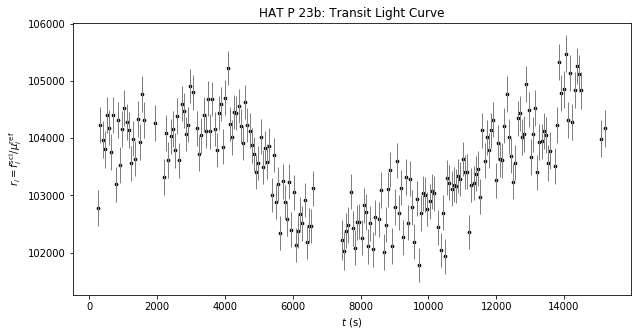

In [37]:
plt.figure(figsize=(10,5))
plt.scatter(time_c,ratios,color="black",s=7)
plt.errorbar(time_c,ratios, yerr=rerr, xerr = None, ecolor='gray',linewidth=1,ls='none');
plt.title('HAT P 23b: Transit Light Curve')
plt.xlabel('$t$ (s)')
plt.ylabel('$r_i = f_{i}^{\mathrm{sci}} / \mu_{i}^{\mathrm{ref}}$')
plt.legend()

plt.savefig('L106.png')

We now plot this same grapth with our expected transit start, midpoint, and end times labeled:

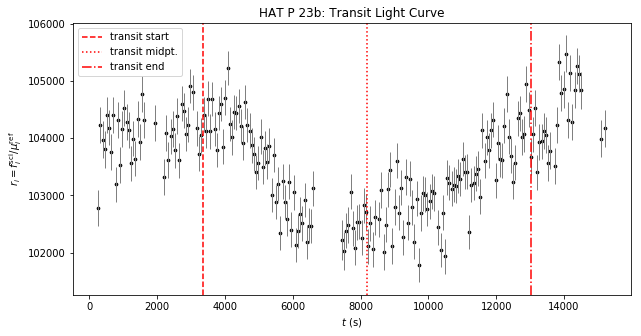

In [38]:
 # times of transit strt, midpt., end (UTC)
trans_time_UTC = ['01:35:54.00','02:56:36.00','04:17:18.00']
trans_time     = []

# converting to seconds since observation start
for i,t in enumerate(trans_time_UTC):
    curr_t  = datetime.strptime(trans_time_UTC[i],'%H:%M:%S.%f') 
    new_t   = (curr_t-start_t).total_seconds()  
    trans_time.append(new_t)
    
plt.figure(figsize=(10,5))
plt.scatter(time_c,ratios,color="black",s=7)
plt.errorbar(time_c,ratios, yerr=rerr, xerr = None, ecolor='gray',linewidth=1,ls='none');
plt.title('HAT P 23b: Transit Light Curve')
plt.xlabel('$t$ (s)')
plt.ylabel('$r_i = f_{i}^{\mathrm{sci}} / \mu_{i}^{\mathrm{ref}}$')
plt.axvline(x=trans_time[0],color='red',linestyle='--',label='transit start')
plt.axvline(x=trans_time[1],color='red',linestyle=':',label='transit midpt.')
plt.axvline(x=trans_time[2],color='red',linestyle='-.',label='transit end')
plt.legend()

plt.savefig('L107.png')

Our transit lines do not quite match up with our data. By looking at the lightcurve to see where the flux begins to dip, we visually estimate our transit to start at about 16 minutes passed our expected time. 

Using the difference of this new ingress time to the mid-transit time, we are also able to find our new time for transit egress. Both our expected and adjusted trasnit points are plotted below:

[3358.428, 8200.428, 13042.428]
transit duration (s) =  7724.0  +/- 120
transit duration (d) =  0.0894  +/- 0.00139


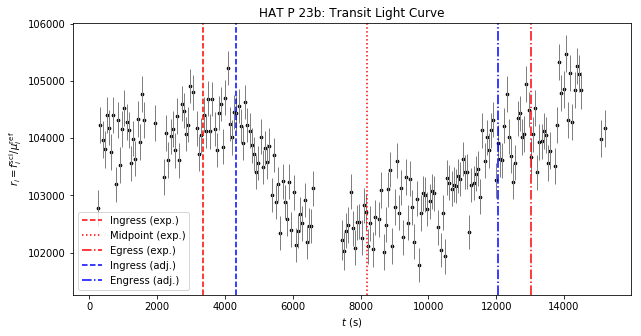

In [39]:
# estimate ingress (transit start)
print(trans_time)
start_adj = 980 # seconds (~15.8 minutes)
                # error of 120 seconds (~3 minutes)
trans_time_adj = []
new_start      = trans_time[0]+start_adj
d              = trans_time[0] - new_start
new_end        = trans_time[2]+d

trans_time_adj.append(new_start)
trans_time_adj.append(new_end)

# calculating transit duration
transit_duration = trans_time_adj[1]-trans_time_adj[0]
td_err           = 120

def day(s):      # convert seconds to days
    ans = s*1.1574074*10**-5  
    return round(ans,5)

print('transit duration (s) = ',transit_duration,' +/-',td_err)
print('transit duration (d) = ',day(transit_duration),' +/-',day(td_err))

plt.figure(figsize=(10,5))
plt.scatter(time_c,ratios,color="black",s=7)
plt.errorbar(time_c,ratios, yerr=rerr, xerr = None, ecolor='gray',linewidth=1,ls='none');
plt.title('HAT P 23b: Transit Light Curve')
plt.xlabel('$t$ (s)')
plt.ylabel('$r_i = f_{i}^{\mathrm{sci}} / \mu_{i}^{\mathrm{ref}}$')

# timescale lines
plt.axvline(x=trans_time[0],color='red',linestyle='--',label='Ingress (exp.)')
plt.axvline(x=trans_time[1],color='red',linestyle=':',label='Midpoint (exp.)')
plt.axvline(x=trans_time[2],color='red',linestyle='-.',label='Egress (exp.)')
plt.axvline(x=trans_time_adj[0],color='blue',linestyle='--',label='Ingress (adj.)')
plt.axvline(x=trans_time_adj[1],color='blue',linestyle='-.',label='Engress (adj.)')
plt.legend()

plt.savefig('L107b.png')

Our adjusted transit ingress and egress times fit our lightcurve much better.

Now that we have our official transit start and end points, we can calculate the baseline flux from the images taken before our transit ingress, and normalize $r_i$ and its error by this value. The ratios here now represent the fraction of light from our science target that is not obscured by the transiting planet.

baseline flux =  104063.55276


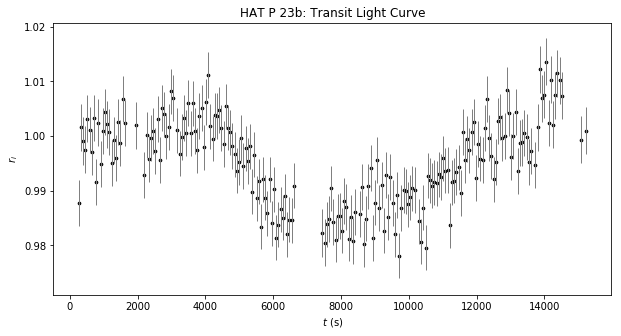

In [40]:
# Calculating Baseline Flux

# transit starts    21:35:54 EDT (1:35 UTC);  01:34:59.293    1.01478
# transit midpoint  22:56:36 EDT (2:56 UTC);  02:55:56.198    0.98015
# transit ends      00:17:18 EDT (4:17 UTC);  04:16:54.976    1.00264
# transit depth     0.01193. 

t_UTC_c    = np.delete(t_UTC,indx)

# calculate baseline by averaging ratios before transit

b_lst    = []     # list to hold baseline values
berr_lst = []     # list to hold baseline errors

for i, t in enumerate(time_c):
    if t < (trans_time[0]):
            b_lst.append(ratios[i])
            berr_lst.append(rerr[i])
            
baseline = np.mean(np.array(b_lst))
base_err = np.mean(np.array(berr_lst))

# normalizing ratios + error by baseline
                   
ratios_norm_lst = []  # list to hold normalized ratios
rerr_norm_lst   = []  # list to hold norm. ratio error
                   
for r in ratios:
    # get baseline to be 1.0,
    v = r/baseline
    ratios_norm_lst.append(v)
    
ratios_norm = np.array(ratios_norm_lst)

for i,r in enumerate(ratios):
    err_a = rerr[i]/ratios[i]
    err_b = base_err/baseline
    err   = ratios_norm[i]*np.sqrt(err_a**2+err_b**2)
    rerr_norm_lst.append(err)
    
rerr_norm = np.array(rerr_norm_lst)  

print('baseline flux = ',round(baseline,5))


plt.figure(figsize=(10,5))
plt.scatter(time_c,ratios_norm,color="black",s=7)
plt.errorbar(time_c,ratios_norm, yerr=rerr_norm, xerr = None, ecolor='gray',linewidth=1,ls='none');

plt.title('HAT P 23b: Transit Light Curve')
plt.xlabel('$t$ (s)')
plt.ylabel('$r_i $')
plt.legend()


plt.savefig('L108.png')

The above raw light curve depicts the normalized $r$ values against time since observation start $t$. 

The value $\epsilon$ is also calculated such that $r_i$ should scatter around
1.0 out of eclipse, and around $1-\epsilon$ during eclipse.

In [41]:
def get_base(loc,base_lst,err_lst):
    b_flux = []
    b_ferr = []
    b_mean = []
    b_merr = []

    for i, t in enumerate(time_c):
        if loc == 'start':
            if t < (trans_time_adj[0]):
                b_flux.append(ratios_norm[i])
                b_ferr.append(rerr_norm[i])
        if loc == 'trans':
            if t > (trans_time_adj[0]) and t < (trans_time_adj[1]):
                b_flux.append(ratios_norm[i])
                b_ferr.append(rerr_norm[i])
    ia = 0
    ib = 0
    
    for j, r in enumerate(b_flux):
        ia += b_flux[j]/b_ferr[j]**2
        ib += 1/b_ferr[j]**2
        c = ia/ib
        d = np.sqrt(1/ib)
    b_mean.append(c)
    b_merr.append(d)

    ja = 0
    jb = 0
    
    for k, r in enumerate(b_mean):
        ja += b_mean[k]/b_merr[k]**2
        jb += 1/b_merr[k]**2
        c  = ja/jb
        dt = np.sqrt(1/jb)
    base_lst.append(c)
    err_lst.append(dt)
    return base_lst
    return err_lst

b_ingress = []
b_ierr    = []
b_transit = []
b_terr    = []
get_base('start',b_ingress,b_ierr)
get_base('trans',b_transit,b_terr)

epsilon = b_ingress[0] - b_transit[0]
ep_err  = np.sqrt(b_ierr[0]**2 + b_terr[0]**2)

print('baseline ratio (r_B) = ',round(b_ingress[0],5),'+/-',round(b_ierr[0],5))
print('transit ratio  (r_T) = ',round(b_transit[0],5),'+/-',round(b_terr[0],5))
print('epsilon              = ',round(epsilon,5),'+/-',round(ep_err,5))
print()
print('transit depth        = ',round(100*epsilon,5),'+/-',round(100*ep_err,5),'%')

baseline ratio (r_B) =  1.00081 +/- 0.00057
transit ratio  (r_T) =  0.99018 +/- 0.0004
epsilon              =  0.01063 +/- 0.0007

transit depth        =  1.06319 +/- 0.06959 %


Our values for baseline ratio, transit ratio, and epsilon are seen above. Epsilon is used to calculate transit depth, of which we found to be $1.063 \pm 0.070$%. The weighted mean was used to calculate $r_B$ and $r_T$

Below we plot our final light curve with expected and adjusted transit points:

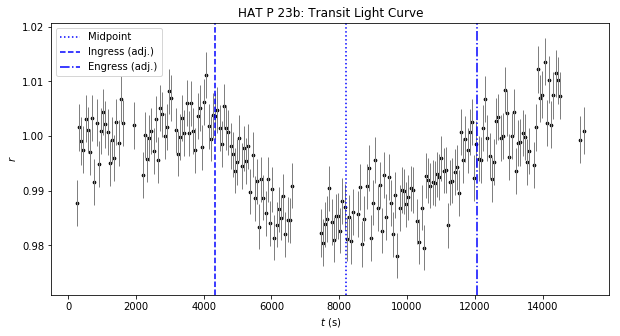

In [42]:
plt.figure(figsize=(10,5))
plt.scatter(time_c,ratios_norm,color="black",s=7)
plt.errorbar(time_c,ratios_norm, yerr=rerr_norm, xerr = None, ecolor='gray',linewidth=1,ls='none');
plt.title('HAT P 23b: Transit Light Curve')
plt.xlabel('$t$ (s)')
plt.ylabel('$r$')
plt.axvline(x=trans_time[1],color='blue',linestyle=':',label='Midpoint')
plt.axvline(x=trans_time_adj[0],color='blue',linestyle='--',label='Ingress (adj.)')
plt.axvline(x=trans_time_adj[1],color='blue',linestyle='-.',label='Engress (adj.)')
plt.legend()

plt.savefig('L109.png')



#### Planet Radius

The planet-star radius ratio can be caluclated by taking the square root of the depth of the transit, such that:

In [43]:
ps_ratio = np.sqrt(epsilon)
ps_rerr  = ep_err/(np.sqrt(epsilon)*2) # error

print('planet-star radius ratio = ',round(ps_ratio,4),' +/-',round(ps_rerr,4))

planet-star radius ratio =  0.1031  +/- 0.0034
